# Imagewoof CNN Classifier - PyTorch 

In this notebook, I'll be training a convolutional neural network in PyTorch on a GPU on the imagewoof dataset (from [here](https://github.com/fastai/imagenette)) containing ~10000 samples of 10 classes of different dog breeds. 

## 1. Data import and visualization

In [1]:
import numpy as np
import gzip

data_path = "../../data/imagewoof.npy.gz"
f = gzip.GzipFile(data_path, "r")
data_set = np.load(f, allow_pickle=True)

In [130]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
from torchvision import datasets
from torch.utils.data import DataLoader
from util import *

In [139]:
from torch.utils.data import Dataset, TensorDataset

class GetDataset(Dataset):
    def __init__(self, data_set): # samples and labels are stored in tuples in data_set (list)
        self.data_distribution = data_set
    
    def __getitem__(self, index):
        sample = self.data_distribution[index][0]
        label = self.data_distribution[index][1]
        return (torch.tensor(sample, dtype=torch.float), torch.tensor(label, dtype=torch.int64)) 
    
    def __len__(self):
        return len(self.data_distribution)

In [140]:
torch_set = GetDataset(data_set)

In [141]:
torch_set.__len__()

9025

In [142]:
TRAIN_RATIO = 0.8  # 80/20 split (customize to your liking) 
train_size = int(TRAIN_RATIO * len(torch_set))
test_size = len(torch_set) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(torch_set, [train_size, test_size])

In [143]:
train_dataset.__len__()

7220

In [144]:
test_dataset.__len__()

1805

In [145]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32) 
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)

In [146]:
for sample in trainloader:
    print(sample[0].shape)
    print(sample[1])
    break

torch.Size([32, 3, 160, 160])
tensor([1, 1, 4, 0, 6, 6, 1, 9, 6, 2, 0, 8, 8, 7, 3, 4, 0, 6, 1, 2, 8, 2, 4, 3,
        7, 1, 0, 1, 0, 6, 4, 5])


Data formatting: each sample is a batch of 32. `sample` is a list containing two tensors: one holding the image samples and the other holding the labels. In a batch of 32. i.e. all of the x's are in a tensor of length 32 and all of the y's are in a list of same length. Let us do some plotting: 

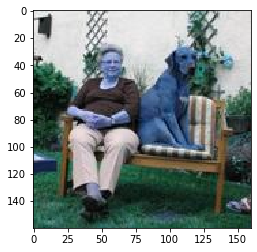

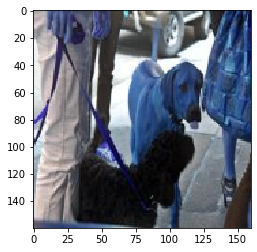

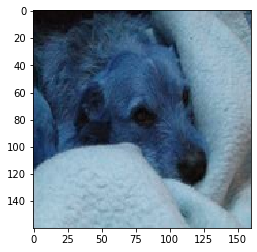

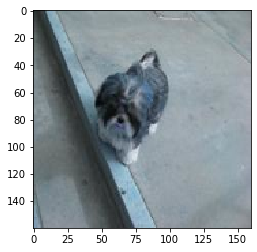

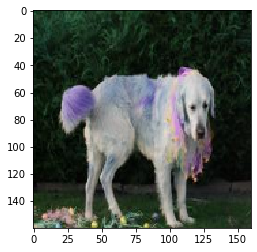

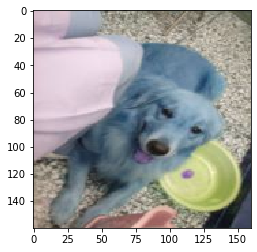

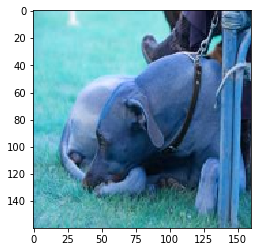

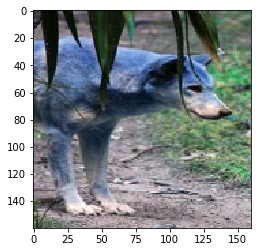

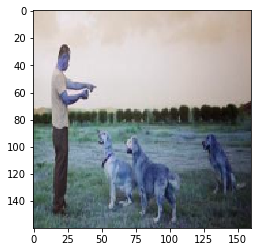

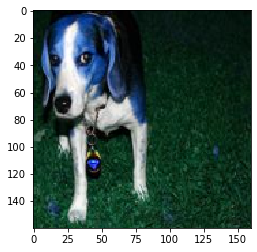

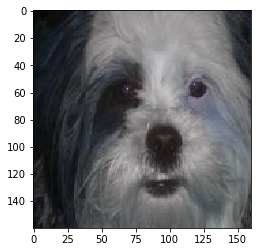

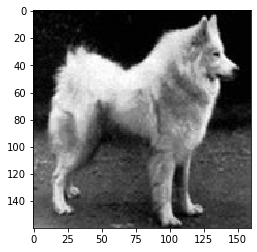

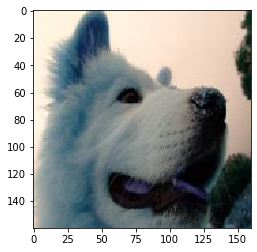

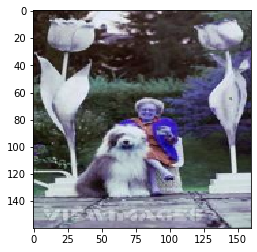

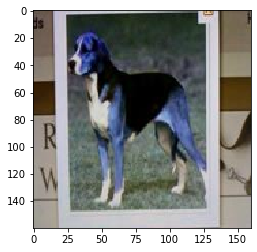

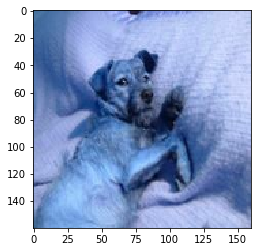

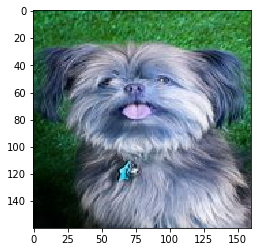

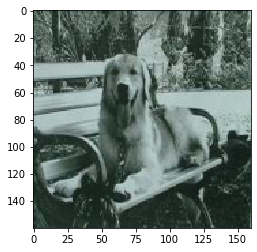

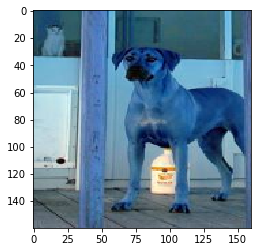

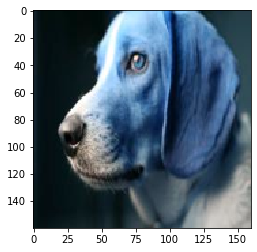

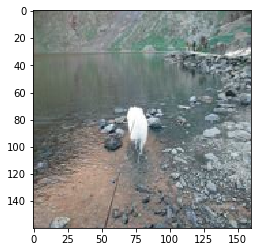

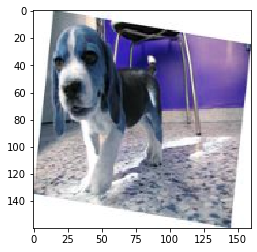

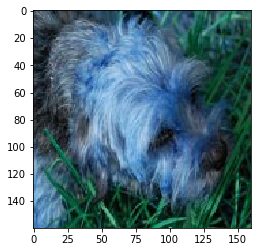

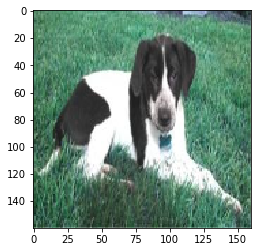

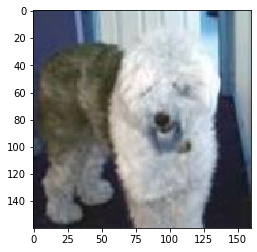

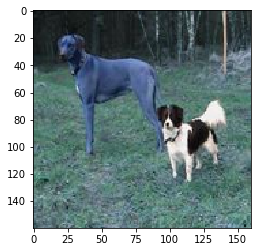

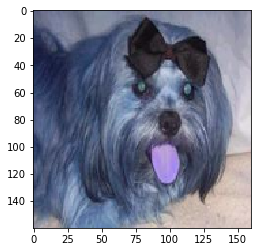

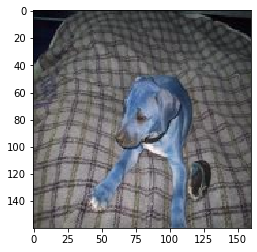

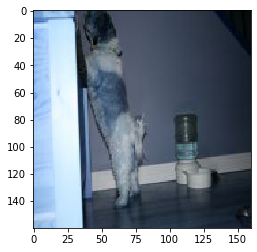

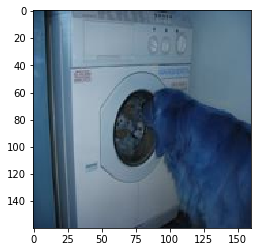

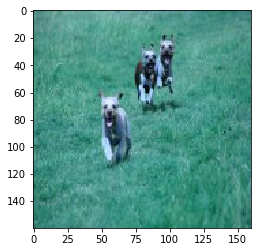

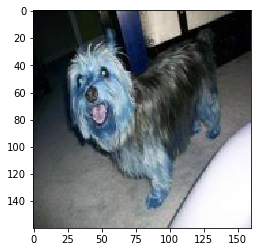

In [152]:
for batch in trainloader:
    images = sample[0]
    labels = sample[1]
    for image in images:
        plot_image = torch.movedim(image, 0, 2)
        plot_tensor(plot_image, True)
    break

## 2. Build the model 

In [153]:
import torch.nn as nn
import torch.nn.functional as F

In [154]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # conv layers 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # pool 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # fc
        self.fc1 = nn.Linear(16 * 40 * 40, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        

    def forward(self, x):
        # conv 
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        # fc 
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [155]:
net = Net()
net

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [156]:
pytorch_total_params = sum(p.numel() for p in net.parameters())
pytorch_total_params

3287226

In [157]:
param_size = 0
for param in net.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in net.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('network size: {:.3f}MB'.format(size_all_mb))

network size: 12.540MB


In [158]:
for batch in trainloader:
    out = net(batch[0])
    print(out.shape)
    print(batch[1].shape)
    break

torch.Size([32, 10])
torch.Size([32])


**GPU**: 

In [159]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [160]:
net.to(device)

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

## 3. Train 

In [166]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
MOMENTUM_VALUE = 0.9
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_VALUE)

In [167]:
%%time
from tqdm import tqdm
enum = 0
elosses = []
NUM_EPOCHS = 50

for epoch in range(NUM_EPOCHS):
    enum += 1
    running_loss = 0.0
    
    for data in trainloader:
        # 1. get data 
        inputs = data[0].to(device)
        labels = data[1].to(device)
        
        # 2. zero out grads 
        optimizer.zero_grad()
        
        # 3. forward + backward + optimize
        logits = net(inputs)
        loss_val = criterion(logits, labels)
        loss_val.backward()
        optimizer.step()
        
        running_loss += loss_val
    
    epoch_loss = (running_loss/len(trainloader)).cpu().detach().numpy()
    elosses.append(epoch_loss)
    print('Loss epoch {}: '.format(enum), epoch_loss)

Loss epoch 1:  2.037393
Loss epoch 2:  2.0232034
Loss epoch 3:  2.0071898
Loss epoch 4:  1.9874042
Loss epoch 5:  1.9632303
Loss epoch 6:  1.937242
Loss epoch 7:  1.9147476
Loss epoch 8:  1.8955843
Loss epoch 9:  1.877413
Loss epoch 10:  1.8577684
Loss epoch 11:  1.8370476
Loss epoch 12:  1.8150216
Loss epoch 13:  1.7908
Loss epoch 14:  1.7651358
Loss epoch 15:  1.7361295
Loss epoch 16:  1.7048289
Loss epoch 17:  1.6684059
Loss epoch 18:  1.6299838
Loss epoch 19:  1.5871325
Loss epoch 20:  1.5431354
Loss epoch 21:  1.4902581
Loss epoch 22:  1.4361638
Loss epoch 23:  1.3708892
Loss epoch 24:  1.3046732
Loss epoch 25:  1.2275178
Loss epoch 26:  1.1499839
Loss epoch 27:  1.0673999
Loss epoch 28:  1.0151758
Loss epoch 29:  0.96524626
Loss epoch 30:  0.9389177
Loss epoch 31:  0.888715
Loss epoch 32:  0.81379515
Loss epoch 33:  0.7173477
Loss epoch 34:  0.6235766
Loss epoch 35:  0.5790383
Loss epoch 36:  0.53010935
Loss epoch 37:  0.48966202
Loss epoch 38:  0.47161072
Loss epoch 39:  0.47051

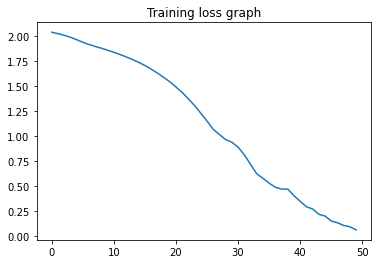

In [168]:
import matplotlib.pyplot as plt
plt.plot(elosses)
plt.title("Training loss graph")
plt.show()

## 5. Test 

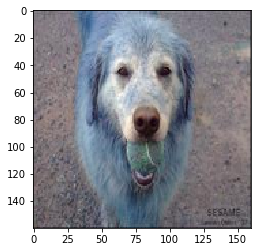

Ground truth:  6
Predicted label:  6
------------------------


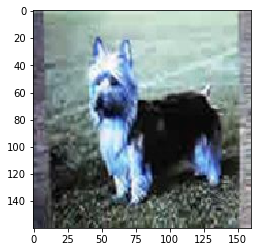

Ground truth:  5
Predicted label:  5
------------------------


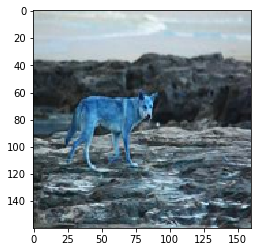

Ground truth:  9
Predicted label:  9
------------------------


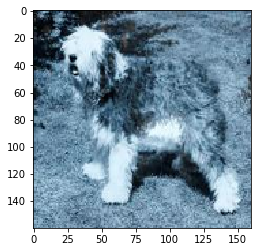

Ground truth:  7
Predicted label:  7
------------------------


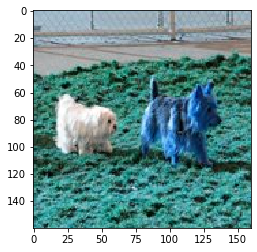

Ground truth:  5
Predicted label:  9
------------------------


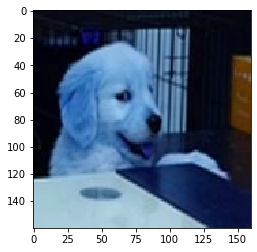

Ground truth:  6
Predicted label:  5
------------------------


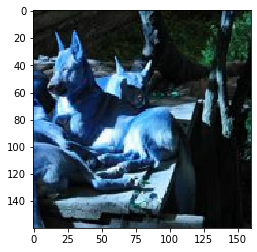

Ground truth:  9
Predicted label:  6
------------------------


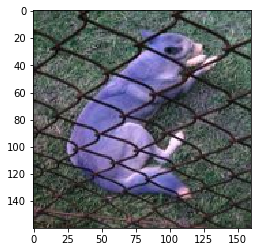

Ground truth:  9
Predicted label:  1
------------------------


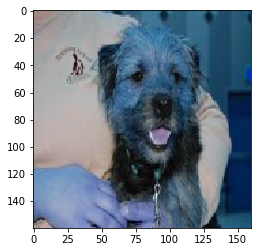

Ground truth:  4
Predicted label:  5
------------------------


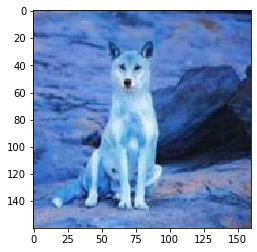

Ground truth:  9
Predicted label:  2
------------------------


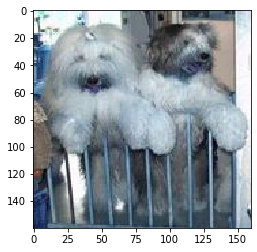

Ground truth:  7
Predicted label:  8
------------------------
Accuracy on test set:  36.36363636363637


In [187]:
accuracy_count = 0
idx_count = 0

with torch.no_grad():
    for data in testloader:
        # setup 
        images = data[0]  # plotting 
        images = torch.squeeze(images)
        images = torch.movedim(images, 0, 2)
        inputs = data[0].to(device)
        labels = data[1].to(device)
        label = labels.item()
        logits = net(inputs)
        normalized_logits = F.softmax(logits, dim=1)
        preds = torch.argmax(normalized_logits)
        pred = preds.item()

        # calculate 
        if (label == pred):
            accuracy_count += 1
        idx_count += 1

        # display 
        plot_tensor(images, True)
        print("Ground truth: ", label)
        print("Predicted label: ", pred)
        print("------------------------")
        
        if idx_count > 10: 
            break
    
total_accuracy = accuracy_count/idx_count
print("Accuracy on test set: ", total_accuracy * 100)